In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st

Gillespie SIR (Stochastic model)

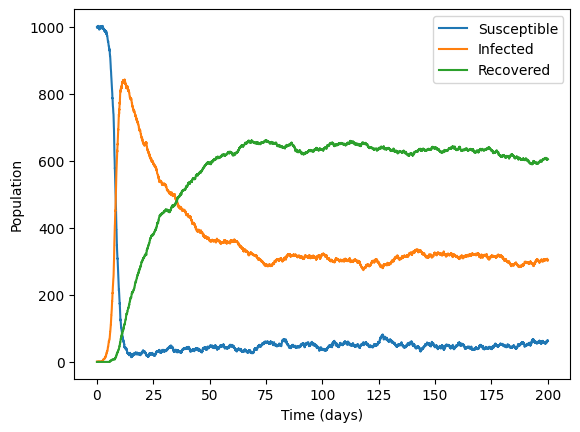

In [41]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # initialize arrays to store the variables
    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Calculate rates for all events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # if rate_sum is zero, no more events possible
        if rate_sum <= 0:
            break  # No more events can happen, end the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)  # Append the new time

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # determine which event happens
        if rand < (cum_rate := cum_rate + birth_rate): # birth event
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # infection event
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # recovery event
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch


N = 1000
tend = 200 # simulation time (200 days)
beta = 1
gamma = 1/30
mu = 1/60
X0 = 999
Y0 = 1
Z0 = 0
seed = 42

Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plot the results
plt.plot(t, Xs, label="Susceptible")
plt.plot(t, Ys, label="Infected")
plt.plot(t, Zs, label="Recovered")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()
plt.show()

Deterministic SIR model

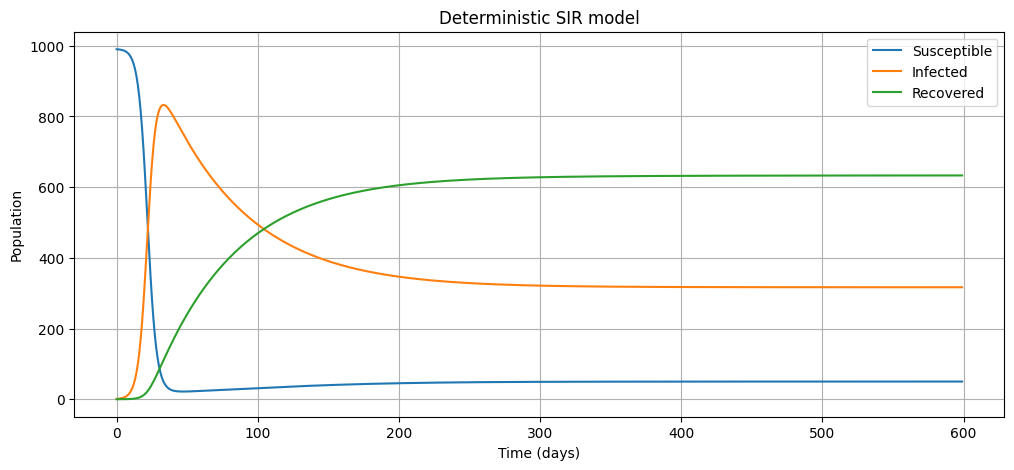

In [42]:
beta = 1
gamma = 1/30
mu = 1/60
N = 1000
X0 = 990
Y0 = 1
Z0 = 0
start_t = 0
end_t = 200
points_t = 600
init_val = [X0, Y0, Z0]

def SIR(val, t, beta, gamma, mu, N):
    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])


def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]
    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det


Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

plt.figure(figsize=(12,5))
plt.plot(Xd, label="Susceptible")
plt.plot(Yd, label="Infected")
plt.plot(Zd, label = "Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("Deterministic SIR model")
plt.legend()
plt.grid()
# plt.savefig('FittingSIR.png', dpi=300)
plt.show()


Plotting deterministic and stochastic SIR

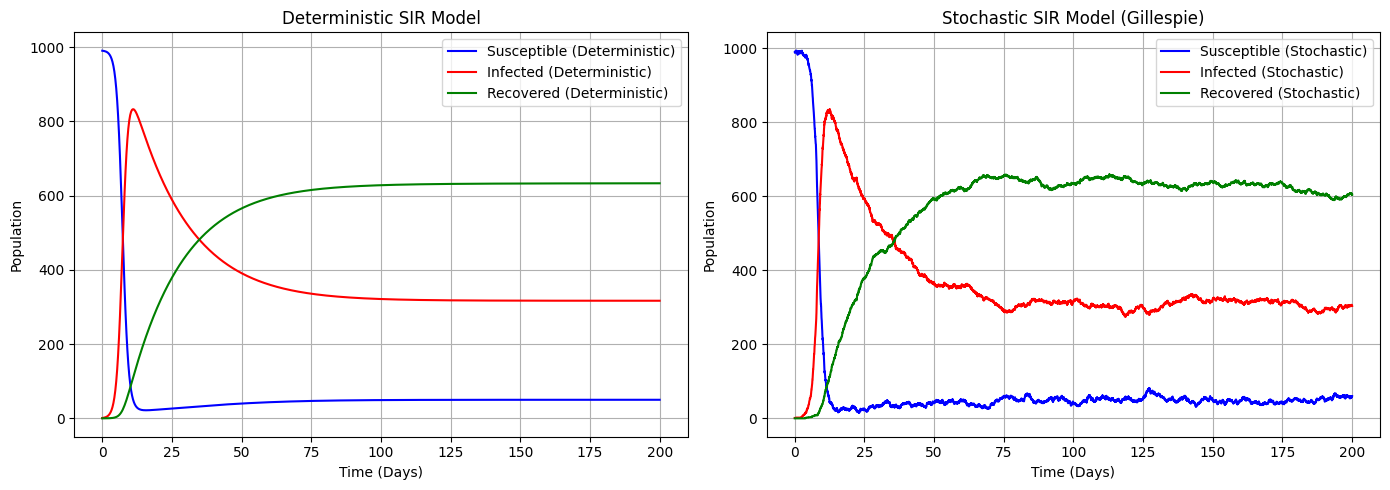

In [43]:
# solve the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
# solve the stochastic model using the Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the deterministic model on the first subplot (ax1)
ax1.plot(time, Xd, label="Susceptible (Deterministic)", color='blue')
ax1.plot(time, Yd, label="Infected (Deterministic)", color='red')
ax1.plot(time, Zd, label="Recovered (Deterministic)", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

# Plot the stochastic model on the second subplot (ax2)
ax2.plot(t, Xs, label="Susceptible (Stochastic)", color='blue')
ax2.plot(t, Ys, label="Infected (Stochastic)", color='red')
ax2.plot(t, Zs, label="Recovered (Stochastic)", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Function to run multiple simulations of Gillespie's agorithm and return mean and variance of X, Y, Z across simulations

Number of simulations: 50
Final mean of Susceptibles: 68.99484802374609
Final variance of Susceptibles: 17715.037955501102
Final mean of Infected: 308.5642889937586
Final variance of Infected: 2303.4672852172243


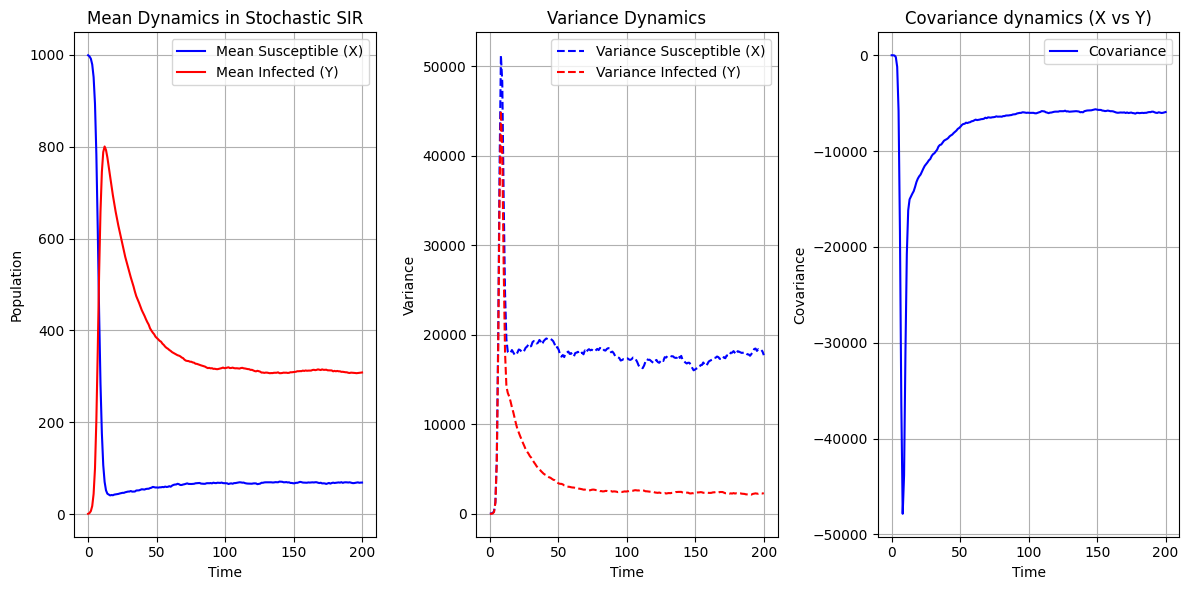

In [14]:
# Assuming gillespie_sir is defined elsewhere
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed):
    # will accumulate Xs, Ys, Zs across simulations
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []
    cov_array = np.zeros(tend)

    time_p = np.linspace(0, tend, 200) # 200 time points

    for i in range(sims):
        # Run the Gillespie simulation for the current iteration
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    # average population size of each compartment at each time point
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # variability of population sizes from the mean across different simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    return time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys

def covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend):

    cov_Xs_Ys = np.zeros(tend)

    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    
    return cov_Xs_Ys

def mean_det_inf(sims, X0, Y0, Z0, Yd, beta, gamma, mu, N, tend):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, 0, tend, 200)
    mean_Yd = np.mean(Yd, axis=0)      
    return mean_Yd

sims = 50
X0 = 999
Y0 = 1
Z0 = 0
beta = 1
gamma = 1/30
mu = 1/60
N = X0 + Y0 + Z0
tend = 200

# Run the stochastic simulations
time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend)

# Print the results
print(f"Number of simulations: {sims}")
print(f"Final mean of Susceptibles: {mean_Xs[-1]}")
print(f"Final variance of Susceptibles: {var_Xs[-1]}")
print(f"Final mean of Infected: {mean_Ys[-1]}")
print(f"Final variance of Infected: {var_Ys[-1]}")


# plotting the mean and the variance
fig, axes = plt.subplots(1, 3, figsize = (12,6))

# Plot Mean on the first subplot (axes[0])
axes[0].plot(time_p, mean_Xs, label='Mean Susceptible (X)', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected (Y)', color='red')
axes[0].set_title("Mean Dynamics in Stochastic SIR")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible (X)', color='blue', linestyle='--')
axes[1].plot(time_p, var_Ys, label='Variance Infected (Y)', color='red', linestyle='--')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance', color='blue')
axes[2].set_title("Covariance dynamics (X vs Y)")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

# Adjust spacing between the two plots
plt.tight_layout()


# Varying model parameters

In [31]:
# Fixed parameters
N = 1000
beta = 1
gamma = 1/3
mu = 1/60
sims = 5

Varying N

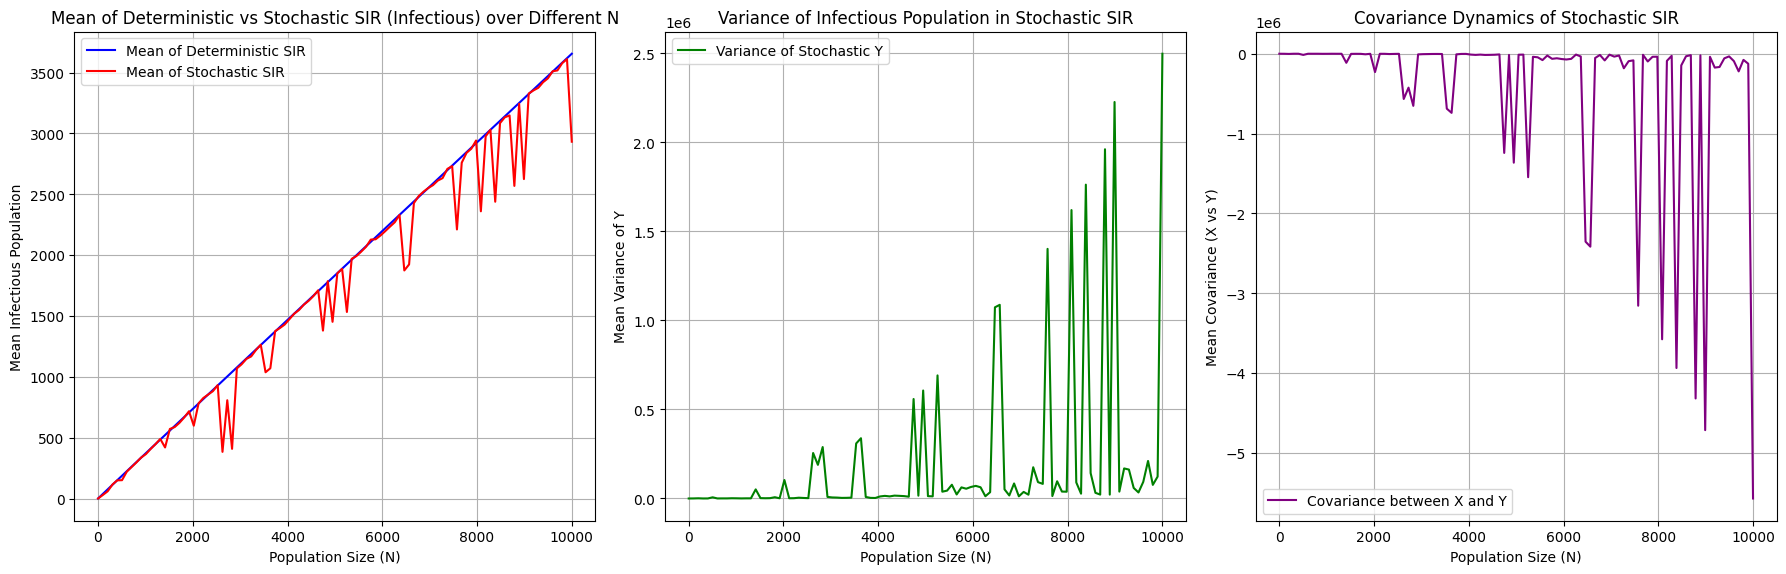

([np.float64(0.7616064062338436),
  np.float64(38.06114016513106),
  np.float64(75.51534161237767),
  np.float64(112.88237494367972),
  np.float64(150.1926871939434),
  np.float64(187.46078414112316),
  np.float64(224.69522175111422),
  np.float64(261.901659030633),
  np.float64(299.08411919491607),
  np.float64(336.2456135846983),
  np.float64(373.3884791421489),
  np.float64(410.51458236297344),
  np.float64(447.6254515548753),
  np.float64(484.7223581585208),
  np.float64(521.8063793193697),
  np.float64(558.8784298556376),
  np.float64(595.9393174368914),
  np.float64(632.9897338078794),
  np.float64(670.03029623094),
  np.float64(707.0615553990917),
  np.float64(744.0839953587162),
  np.float64(781.0980654930877),
  np.float64(818.1041599087905),
  np.float64(855.1026366980582),
  np.float64(892.093835312716),
  np.float64(929.0780554450129),
  np.float64(966.0555762300282),
  np.float64(1003.0266553829148),
  np.float64(1039.9915318406718),
  np.float64(1076.9504306658582),
  np.

In [28]:
# Different values of population
N_diff = np.linspace(2, 10000, 100)

def diff_params_N(N_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different population sizes
    for n in np.nditer(N_diff):
        X0 = int(n) - 1  # Initial susceptible population
        Y0 = 1            # Initial infected population
        Z0 = 0            # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, int(n), tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(n), beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append final mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the final mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the final mean for stochastic Y
        
        # Append final variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append final covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different N")
    axes[0].set_xlabel("Population Size (N)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(N_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over N
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Population Size (N)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(N_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over N
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Population Size (N)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

diff_params_N(N_diff, sims, beta, gamma, mu)

Varying Y0 (initial number of infectious individuals)

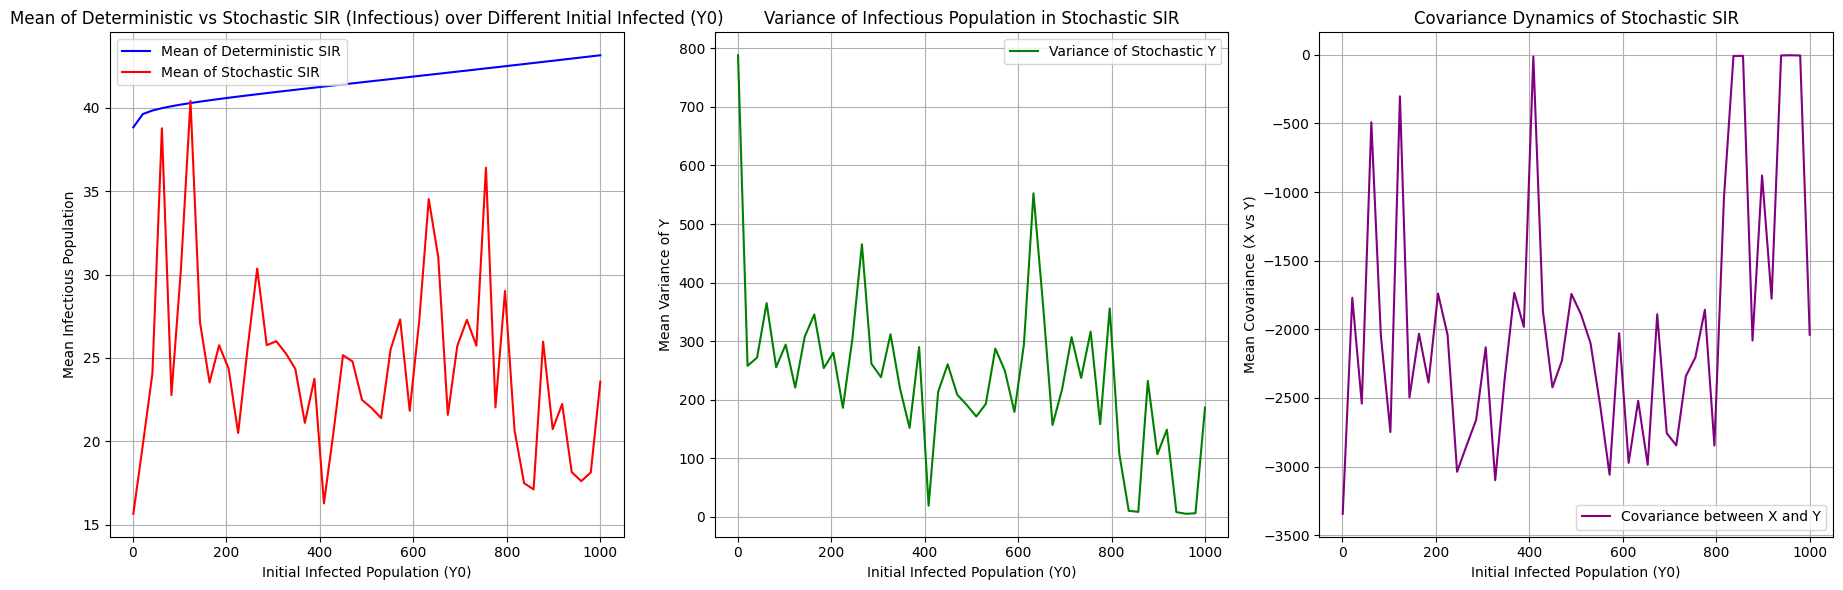

([np.float64(38.83661873281555),
  np.float64(39.63116133509062),
  np.float64(39.840531625276256),
  np.float64(39.98374281460865),
  np.float64(40.099487583414856),
  np.float64(40.20019951783365),
  np.float64(40.29147975169117),
  np.float64(40.376336718908085),
  np.float64(40.45657389841985),
  np.float64(40.5333588421937),
  np.float64(40.60749166046536),
  np.float64(40.67954370881446),
  np.float64(40.74993791897318),
  np.float64(40.818996249739946),
  np.float64(40.88696951836507),
  np.float64(40.95405608242545),
  np.float64(41.020416766687724),
  np.float64(41.086182738860025),
  np.float64(41.15146262887671),
  np.float64(41.21634738154697),
  np.float64(41.28091427369813),
  np.float64(41.34522805656681),
  np.float64(41.4093450207486),
  np.float64(41.473313915794854),
  np.float64(41.53717577321484),
  np.float64(41.60096757768716),
  np.float64(41.66472086207156),
  np.float64(41.72846377998962),
  np.float64(41.79222061046627),
  np.float64(41.85601351235696),
  np.

In [33]:
Y0_diff = np.linspace(1, 1000, 50)

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different initial infected populations Y0
    for y0 in Y0_diff:
        X0 = N - y0  # Initial susceptible population
        Y0 = y0      # Initial infected population
        Z0 = 0       # Initial recovered population
        
        # Run stochastic simulations for the current population size
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current population size
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Initial Infected (Y0)")
    axes[0].set_xlabel("Initial Infected Population (Y0)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Initial Infected Population (Y0)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Initial Infected Population (Y0)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)


In [ ]:
X0 = 999
Y0 = 1
Z0 = 0

Varying beta (transmission rate)

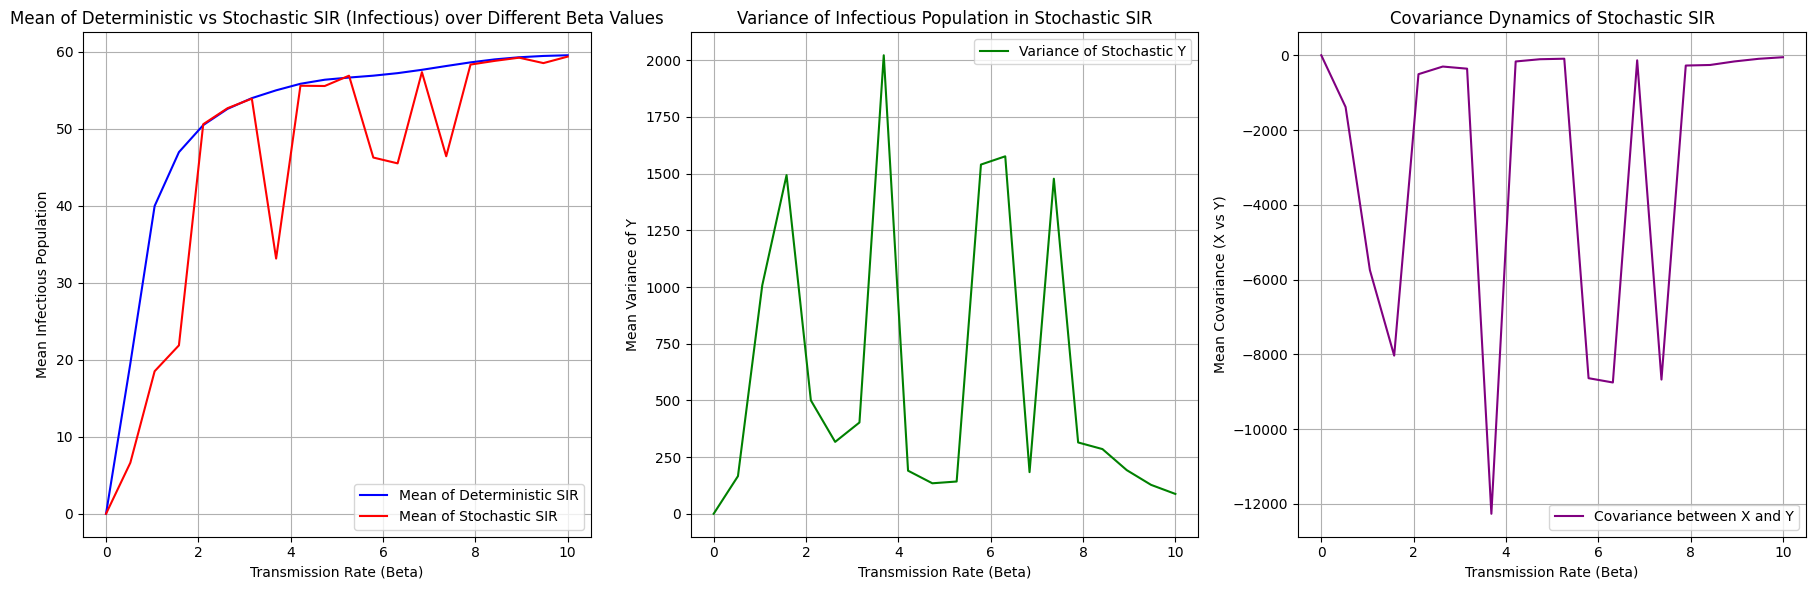

([np.float64(0.016860548643746878),
  np.float64(19.520508210553498),
  np.float64(39.976226998722545),
  np.float64(46.96913462573453),
  np.float64(50.47783144702953),
  np.float64(52.588540136254004),
  np.float64(53.9800239478863),
  np.float64(54.995730663305004),
  np.float64(55.844351907594316),
  np.float64(56.37011679313915),
  np.float64(56.653698797946205),
  np.float64(56.898317028671734),
  np.float64(57.225248832261606),
  np.float64(57.65831527769131),
  np.float64(58.15100762203892),
  np.float64(58.62447272998401),
  np.float64(59.01247075557743),
  np.float64(59.28772964427887),
  np.float64(59.45796142755925),
  np.float64(59.547445849818835)],
 [np.float64(0.015367467427217332),
  np.float64(6.64106141711613),
  np.float64(18.52253547965682),
  np.float64(21.886449618202825),
  np.float64(50.596740723390894),
  np.float64(52.673059525069405),
  np.float64(53.91728713229879),
  np.float64(33.152230943021735),
  np.float64(55.591068828967884),
  np.float64(55.55571601

In [35]:
beta_diff = np.linspace(0, 10, 20)

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different beta values
    for beta in beta_diff:
        
        # Run stochastic simulations for the current beta
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current beta
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Beta Values")
    axes[0].set_xlabel("Transmission Rate (Beta)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over beta
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Transmission Rate (Beta)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over beta
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Transmission Rate (Beta)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with fixed parameters and varying beta
diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

Varying gamma (rate of recovery)

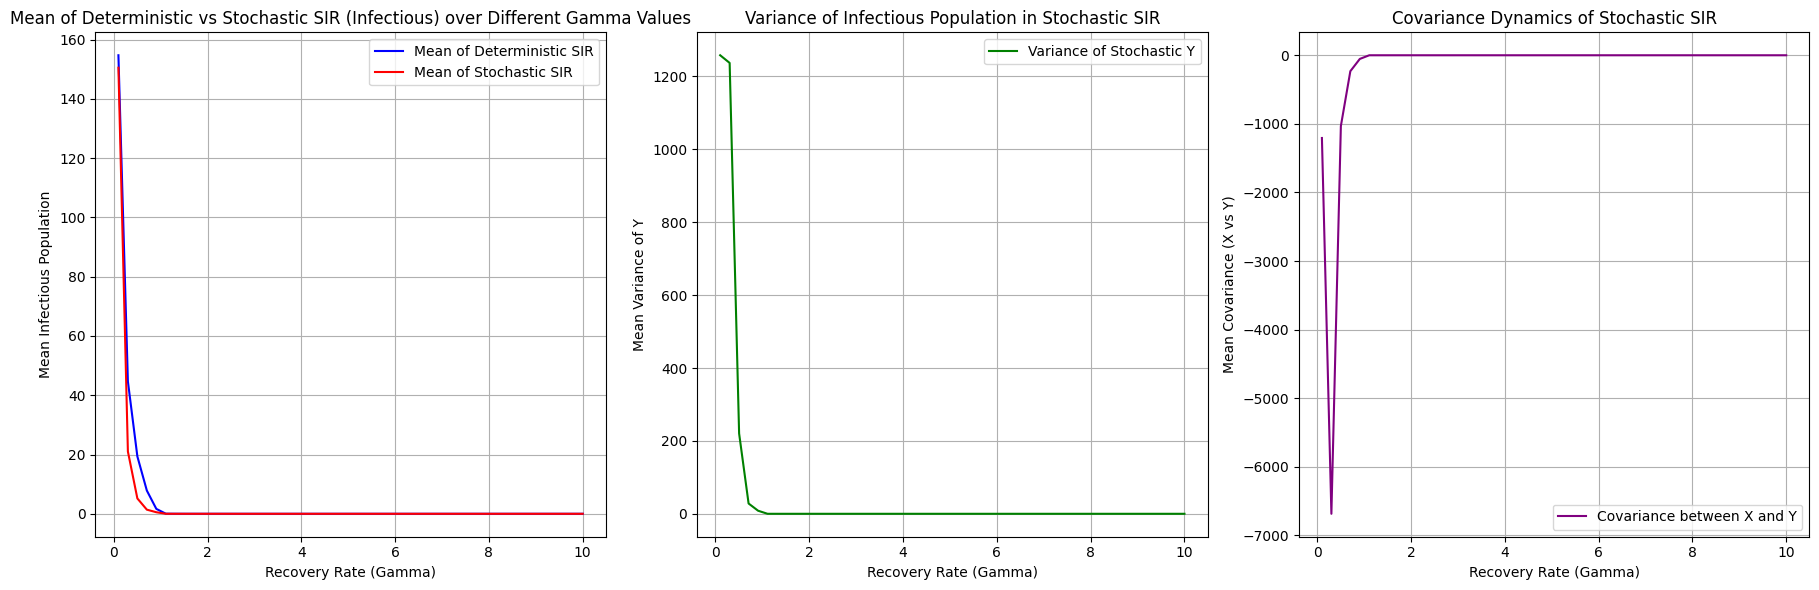

([np.float64(154.7255745958502),
  np.float64(44.686734625661856),
  np.float64(19.364569296887158),
  np.float64(7.848122371296977),
  np.float64(1.6661492186170466),
  np.float64(0.04049159581775069),
  np.float64(0.017654601609169016),
  np.float64(0.01205864784741172),
  np.float64(0.009576699004093641),
  np.float64(0.008198438442859715),
  np.float64(0.00733634179146404),
  np.float64(0.006756331753684227),
  np.float64(0.006346718978605801),
  np.float64(0.006047433613782249),
  np.float64(0.005823280789817539),
  np.float64(0.005652268070585591),
  np.float64(0.005519947788996151),
  np.float64(0.005416446581556264),
  np.float64(0.005334797862800023),
  np.float64(0.005269954472567791),
  np.float64(0.005218183259082239),
  np.float64(0.005176673015753973),
  np.float64(0.005143277483413017),
  np.float64(0.005116336197328388),
  np.float64(0.005094553450962655),
  np.float64(0.005076910922317014),
  np.float64(0.005062600631969212),
  np.float64(0.005050979634578053),
  np.fl

In [37]:
gamma_diff = np.linspace(0.1, 10, 50)


def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different gamma values
    for gamma in gamma_diff:

        # Run stochastic simulations for the current gamma
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current gamma
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Gamma Values")
    axes[0].set_xlabel("Recovery Rate (Gamma)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Recovery Rate (Gamma)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Recovery Rate (Gamma)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with fixed parameters and varying gamma
diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

Varying mu (birth rate)

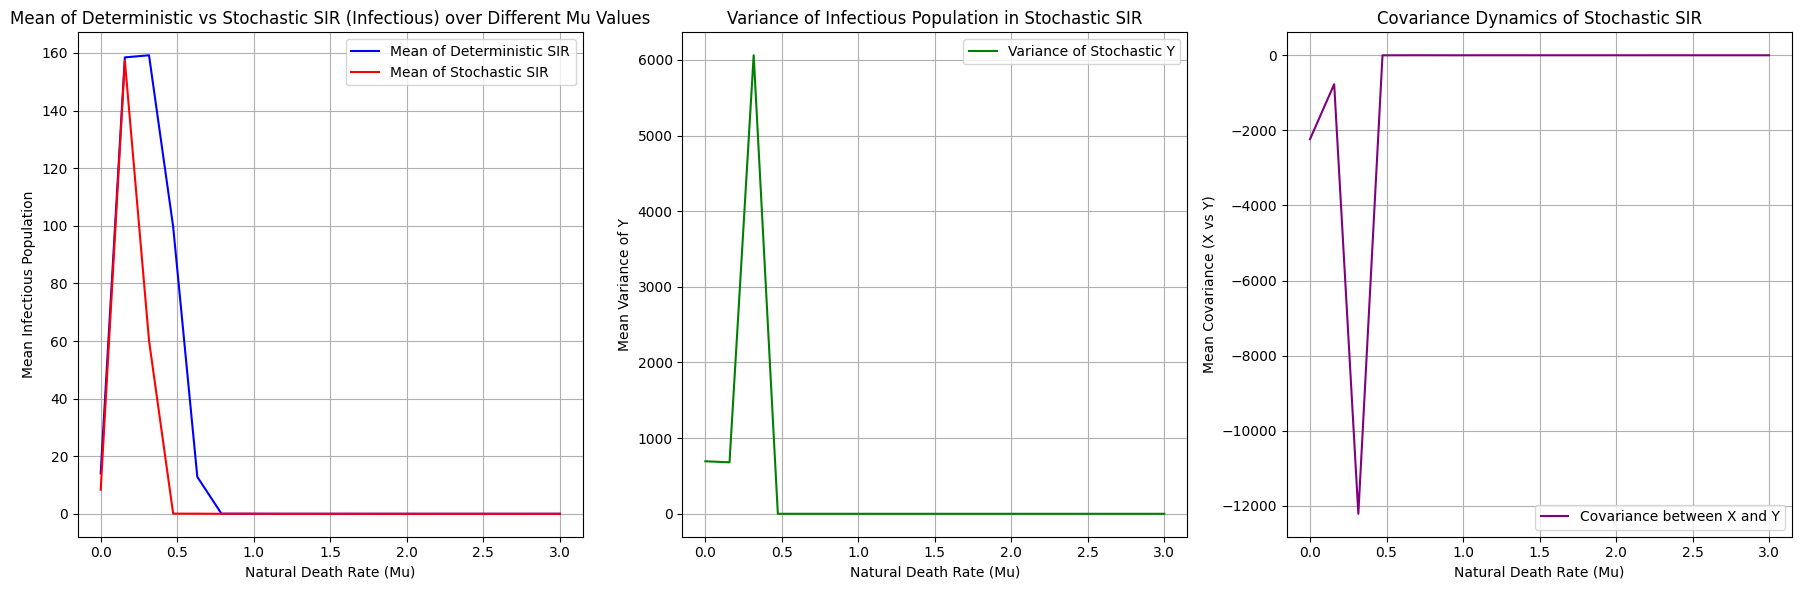

([np.float64(14.039965321719817),
  np.float64(158.47306764618298),
  np.float64(159.21363549893417),
  np.float64(99.67142228681723),
  np.float64(12.824966970983937),
  np.float64(0.042839003397861966),
  np.float64(0.02030123049435818),
  np.float64(0.014010796832400432),
  np.float64(0.011080920606148136),
  np.float64(0.009403054174886526),
  np.float64(0.008327149575733956),
  np.float64(0.007586458981495443),
  np.float64(0.007051279005250761),
  np.float64(0.006650934063187211),
  np.float64(0.006343612034081991),
  np.float64(0.006102985172529012),
  np.float64(0.005911644740942561),
  np.float64(0.005757617344575774),
  np.float64(0.0056323972956140245),
  np.float64(0.005529777870007503)],
 [np.float64(8.35296307431186),
  np.float64(157.34576124526677),
  np.float64(60.17980029939963),
  np.float64(0.064),
  np.float64(0.048),
  np.float64(0.006999999999999999),
  np.float64(0.042),
  np.float64(0.011000000000000001),
  np.float64(0.006),
  np.float64(0.005),
  np.float64(0

In [39]:
mu_diff = np.linspace(0, 3, 20)



def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0):
    
    mean_deter = []  # To store means from the deterministic model
    mean_stoch = []  # To store means from the stochastic model
    var_Y = []       # To store variances of Y
    cov_XY = []      # To store covariances between X and Y

    # Iterate through different mu values
    for mu in mu_diff:
        # Run stochastic simulations for the current mu
        time_p, mean_Xs, mean_Ys, var_Xs, var_Ys, all_Xs, all_Ys = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        
        # Run deterministic model for the current mu
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        # Append mean for deterministic model and stochastic model
        mean_deter.append(np.mean(Yd))  # Store the mean for deterministic Y
        mean_stoch.append(np.mean(mean_Ys))  # Store the mean for stochastic Y
        
        # Append variance of stochastic model
        var_Y.append(np.mean(var_Ys))  # Store the mean variance of stochastic Y over all simulations

        # Calculate and append covariance between susceptible and infected
        cov_Xs_Ys = covariance(all_Xs, all_Ys, mean_Xs, mean_Ys, tend=200)
        cov_XY.append(np.mean(cov_Xs_Ys))  # Store the mean covariance over time

    # Initialize plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Mean Dynamics Plot
    axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
    axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
    axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
    axes[0].set_xlabel("Natural Death Rate (Mu)")
    axes[0].set_ylabel("Mean Infectious Population")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Variance Dynamics Plot
    axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
    axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
    axes[1].set_xlabel("Natural Death Rate (Mu)")
    axes[1].set_ylabel("Mean Variance of Y")
    axes[1].grid(True)
    axes[1].legend()

    # 3. Covariance Dynamics Plot
    axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
    axes[2].set_title("Covariance Dynamics of Stochastic SIR")
    axes[2].set_xlabel("Natural Death Rate (Mu)")
    axes[2].set_ylabel("Mean Covariance (X vs Y)")
    axes[2].grid(True)
    axes[2].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    return mean_deter, mean_stoch, var_Y, cov_XY

# Call the function with varying mu
diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0)

# Extinction event (different R0, fixed population size N)

In [87]:
sims_ext = 10

X0 = 999
Y0 = 1
Z0 = 0

N = 1000 

# R0 = beta / (gamma + mu)

beta_ext = np.linspace(0, 15, sims_ext)
gamma_ext = np.linspace(0.01, 10, sims_ext)
mu_ext = np.linspace(0.01, 3, sims_ext)

R0_ext = beta_ext / (gamma_ext + mu_ext)

Yd_ext = []
Ys_ext = []
extinction_stoch = []  # To track whether extinction happened in stochastic runs
extinction_deter = []  # To track extinction in deterministic runs

for i in range(sims_ext):
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta_ext[i], gamma_ext[i], mu_ext[i], start_t = 0, end_t = 200, points_t = 200)
    Yd_ext.append(Yd[-1])
    extinction_deter.append(1 if Yd[-1] == 0 else 0)

    Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta_ext[i], gamma_ext[i], mu_ext[i], N, tend = 200, seed = i)
    Ys_ext.append(Ys[-1])
    extinction_stoch.append(1 if Ys[-1] == 0 else 0)

print("Stochastic extinctions:", np.sum(extinction_stoch), "out of " f"{sims_ext}" " simulations.")
print("Deterministic extinctions:", np.sum(extinction_deter),"out of " f"{sims_ext}" " simulations.")



Stochastic extinctions: 10 out of 10 simulations.
Deterministic extinctions: 0 out of 10 simulations.
